## dataset from ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

In [27]:
import datetime
import geopandas
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import copy

#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

 # to enable ipympl interactive interface for plots
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


In [28]:
import time
import matplotlib
from distinctipy import distinctipy # generate N distinct colors


In [29]:
#local scripts
from scripts import veg_indices, utilities
#from scripts.utilities import *

In [30]:
BANDS_DICT = {   'B2': 'Blue',
            'B3': 'Green',
            'B4': 'Red',
            'B5': 'Red_Edge_1',
            'B6': 'Red_Edge_2',
            'B7': 'Red_Edge_3',
            'B8': 'NIR',
            'B8A': 'Red_Edge_4',
            'B11': 'SWIR_1',
            'B12': 'SWIR_2'}

BANDS = list(BANDS_DICT.keys())

In [31]:
DF = geopandas.read_file('../data/merged_samples_gdf.geojson')
DF.rename(columns = {'is_within_period':'har_evnt'}, inplace = True)
DF.shape

(8928, 21)

In [32]:
NUM_SAMPLES = len(np.unique(DF.sample_idx))
DF.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,...,finHarvDat,lat,lon,point_idx,start_date,end_date,har_evnt,sample_idx,NDVI_diff,geometry
0,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,...,2022-08-11,50.655048,25.458684,p0,2022-01-29,2022-02-18,False,s0,0.000000,POINT (25.45868 50.65505)
1,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,...,NaT,50.294633,36.289471,p1,2022-01-29,2022-02-18,False,s0,0.000000,POINT (36.28947 50.29463)
2,0.0603,0.0712,0.8832,0.8808,0.8952,0.9323,0.8933,0.8527,0.8808,0.8184,...,NaT,50.860849,32.548484,p2,2022-01-29,2022-02-18,False,s0,-0.008108,POINT (32.54848 50.86085)
3,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,...,NaT,50.928689,31.637558,p3,2022-01-29,2022-02-18,False,s0,0.000000,POINT (31.63756 50.92869)
4,0.1662,0.1304,0.0392,0.0514,0.0719,0.0738,0.0820,0.0886,0.1092,0.0994,...,2022-07-23,48.307964,37.348245,p4,2022-01-29,2022-02-18,False,s0,-0.050371,POINT (37.34824 48.30796)


In [33]:
indices = (DF.loc[(DF.har_evnt == True)]).point_idx
points_with_change_df = DF.loc[(DF.point_idx).isin(indices)]
points_with_change_df.shape # 366 * NUM_SAMPLES rows

df = points_with_change_df
df = df[(df.NDVI) != 0]
vegIndicesNames = veg_indices.add_veg_indices(df)
NUMERIC_COLS = ['NDVI', 'NDVI_diff'] + vegIndicesNames

Added:  ['DVI', 'RVI', 'ARVI', 'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'NDVIre', 'NIRv', 'EVI']


In [34]:
# TODO deal with outliers, then standarize each column
df.columns

Index(['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'NDVI',
       'finHarvDat', 'lat', 'lon', 'point_idx', 'start_date', 'end_date',
       'har_evnt', 'sample_idx', 'NDVI_diff', 'geometry', 'DVI', 'RVI', 'ARVI',
       'NDI45', 'GNDVI', 'MCARI', 'IRECI', 'CIr', 'NDVIre', 'NIRv', 'EVI'],
      dtype='object')

In [17]:
stretch_numeric_df = pd.DataFrame({'value':np.array([]), 'class':np.array([]), 'har_evnt': np.array([]), 'sample_idx':np.array([])})
for col_name in NUMERIC_COLS:
    curr_df = pd.DataFrame({'value': df[col_name], 'class':np.tile(np.array([col_name]), df.shape[0]), 'har_evnt':(df['har_evnt'] == True), 'sample_idx':df['sample_idx'], 'start_date':df['start_date']})
    # _, bools = utilities.rmved_outliers_iqr(df[col_name], True)
    #curr_df = curr_df[bools] # remove the rows where we have outliers
    stretch_numeric_df = pd.concat([stretch_numeric_df, curr_df])
stretch_numeric_df

/var/folders/6q/tw4w22c97c98vxdk2crxzdb00000gn/T/ipykernel_13830/52583405.py:6: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  stretch_numeric_df = pd.concat([stretch_numeric_df, curr_df])


,value,class,har_evnt,sample_idx,start_date
4,0.205964,NDVI,0.0,s0,2022-01-29
10,0.652965,NDVI,0.0,s0,2022-01-29
12,0.555944,NDVI,0.0,s0,2022-01-29
14,0.277152,NDVI,0.0,s0,2022-01-29
15,0.399106,NDVI,0.0,s0,2022-01-29
...,...,...,...,...,...
8901,0.090524,EVI,0.0,s15,2022-12-10
8905,0.071338,EVI,0.0,s15,2022-12-10
8910,0.127251,EVI,0.0,s15,2022-12-10
8917,0.796325,EVI,0.0,s15,2022-12-10


/var/folders/6q/tw4w22c97c98vxdk2crxzdb00000gn/T/ipykernel_13830/3397599987.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(4,8))


<Axes: xlabel='value', ylabel='class'>

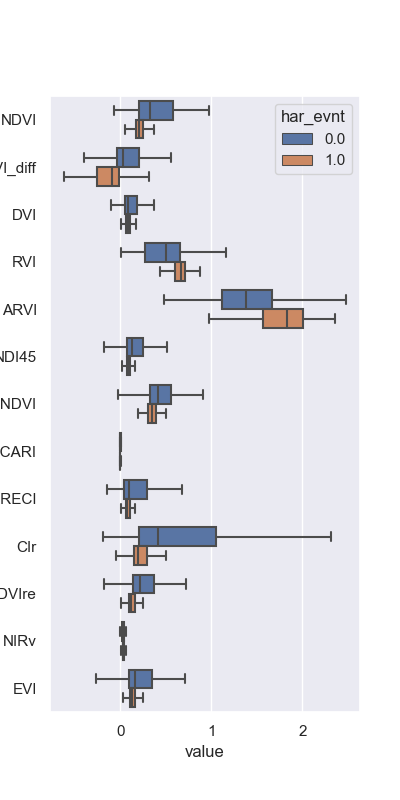

In [52]:
fig = plt.figure(figsize=(4,8))

sns.boxplot(data=stretch_numeric_df, x="value", y="class", hue="har_evnt", showfliers = False) 
                                # set  showfliers  to true to return outliers

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def save_multi_image(filename):
    pp = PdfPages(filename)
    for sampleIdx in stretch_numeric_df.sample_idx.unique():
        curr_df = stretch_numeric_df[stretch_numeric_df.sample_idx == sampleIdx]
        fig = plt.figure(figsize=(16,len(NUMERIC_COLS)))
        sns.boxplot(data=curr_df, x="value", y="class", hue="har_evnt", showfliers = False).set(title= ("Sample Index:", sampleIdx))
        fig.savefig(pp, format='pdf')
    pp.close()


save_multi_image("../plots/plot_with_veggie_no_outliers.pdf")

In [44]:

stretch_numeric_df = pd.DataFrame({'value':np.array([]), 'class':np.array([]), 'har_evnt': np.array([]), 'sample_idx':np.array([])})
for col_name in BANDS:
    curr_df = pd.DataFrame({'value': df[col_name], 'class':np.tile(np.array([col_name]), df.shape[0]), 'har_evnt':(df['har_evnt'] == True), 'sample_idx':df['sample_idx'], 'start_date':df['start_date']})
    
    # _, bools = utilities.rmved_outliers_iqr(df[col_name], True)
    #curr_df = curr_df[bools] # remove the rows where we have outliers

    stretch_numeric_df = pd.concat([stretch_numeric_df, curr_df])
stretch_numeric_df

/var/folders/6q/tw4w22c97c98vxdk2crxzdb00000gn/T/ipykernel_13830/2566655334.py:8: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  stretch_numeric_df_trimmed_by_harv = pd.concat([stretch_numeric_df_trimmed_by_harv, curr_df_trimmed_by_harv])


,value,class,har_evnt,sample_idx,start_date
3116,0.03170,B2,1.0,s5,2022-05-14
3363,0.05800,B2,1.0,s6,2022-06-04
3364,0.14780,B2,1.0,s6,2022-06-04
3420,0.09860,B2,1.0,s6,2022-06-04
3447,0.07200,B2,1.0,s6,2022-06-04
...,...,...,...,...,...
8901,0.12870,B12,0.0,s15,2022-12-10
8905,0.18640,B12,0.0,s15,2022-12-10
8910,0.11750,B12,0.0,s15,2022-12-10
8917,0.22820,B12,0.0,s15,2022-12-10


<Axes: xlabel='start_date', ylabel='value'>

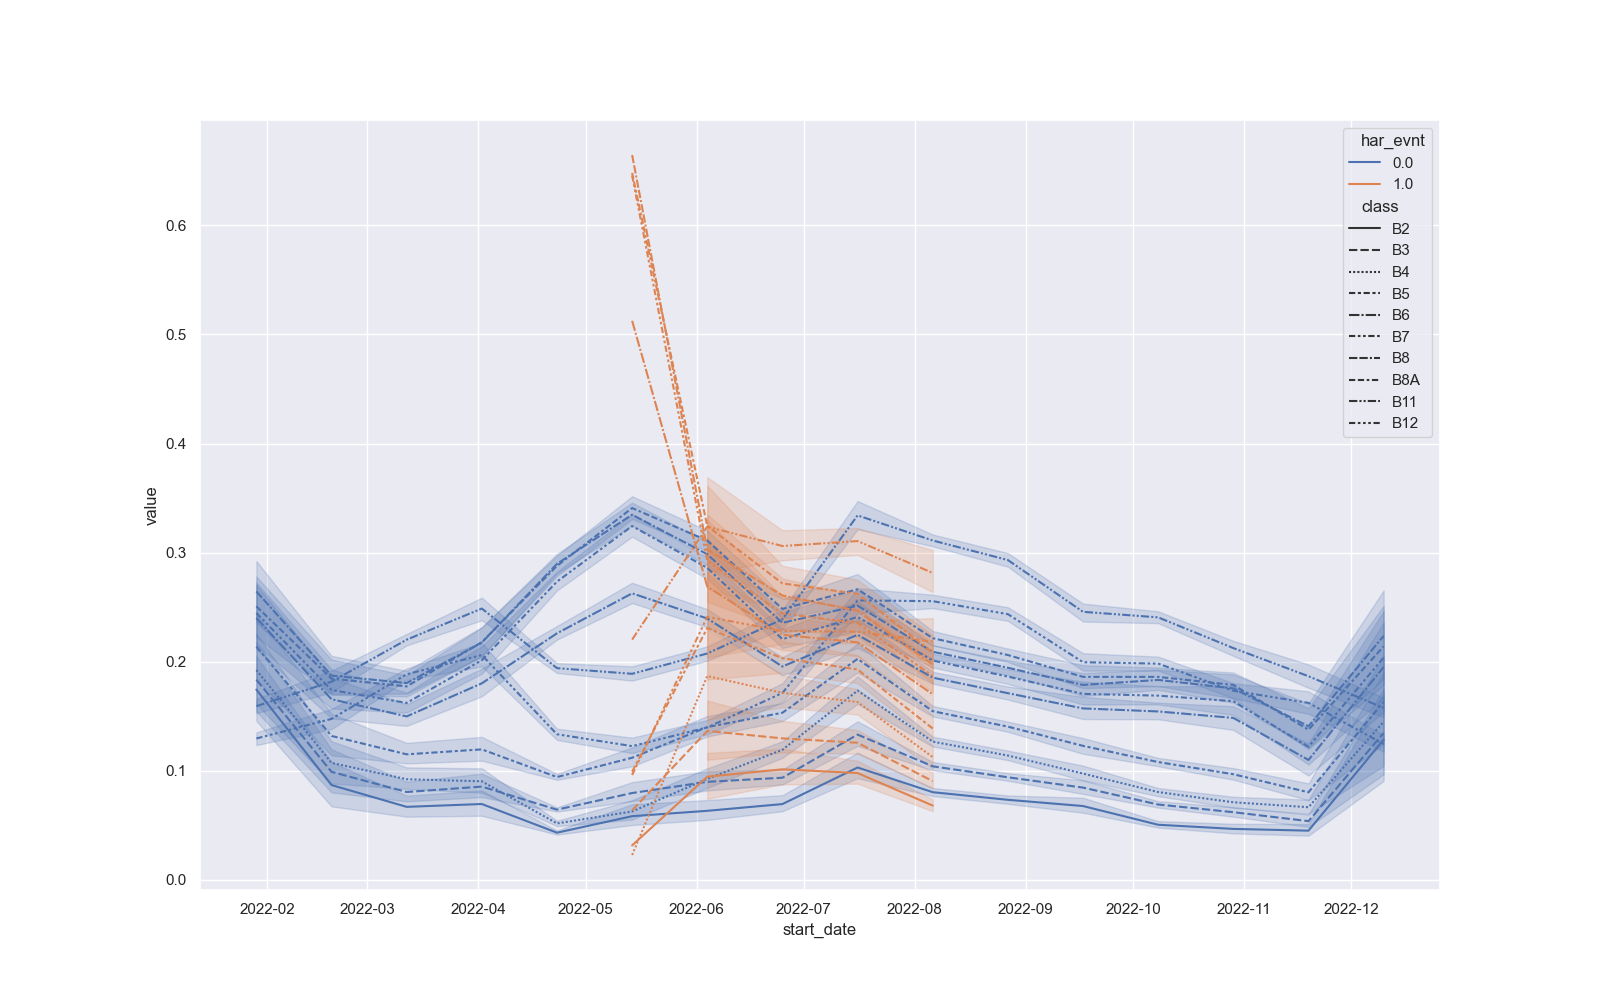

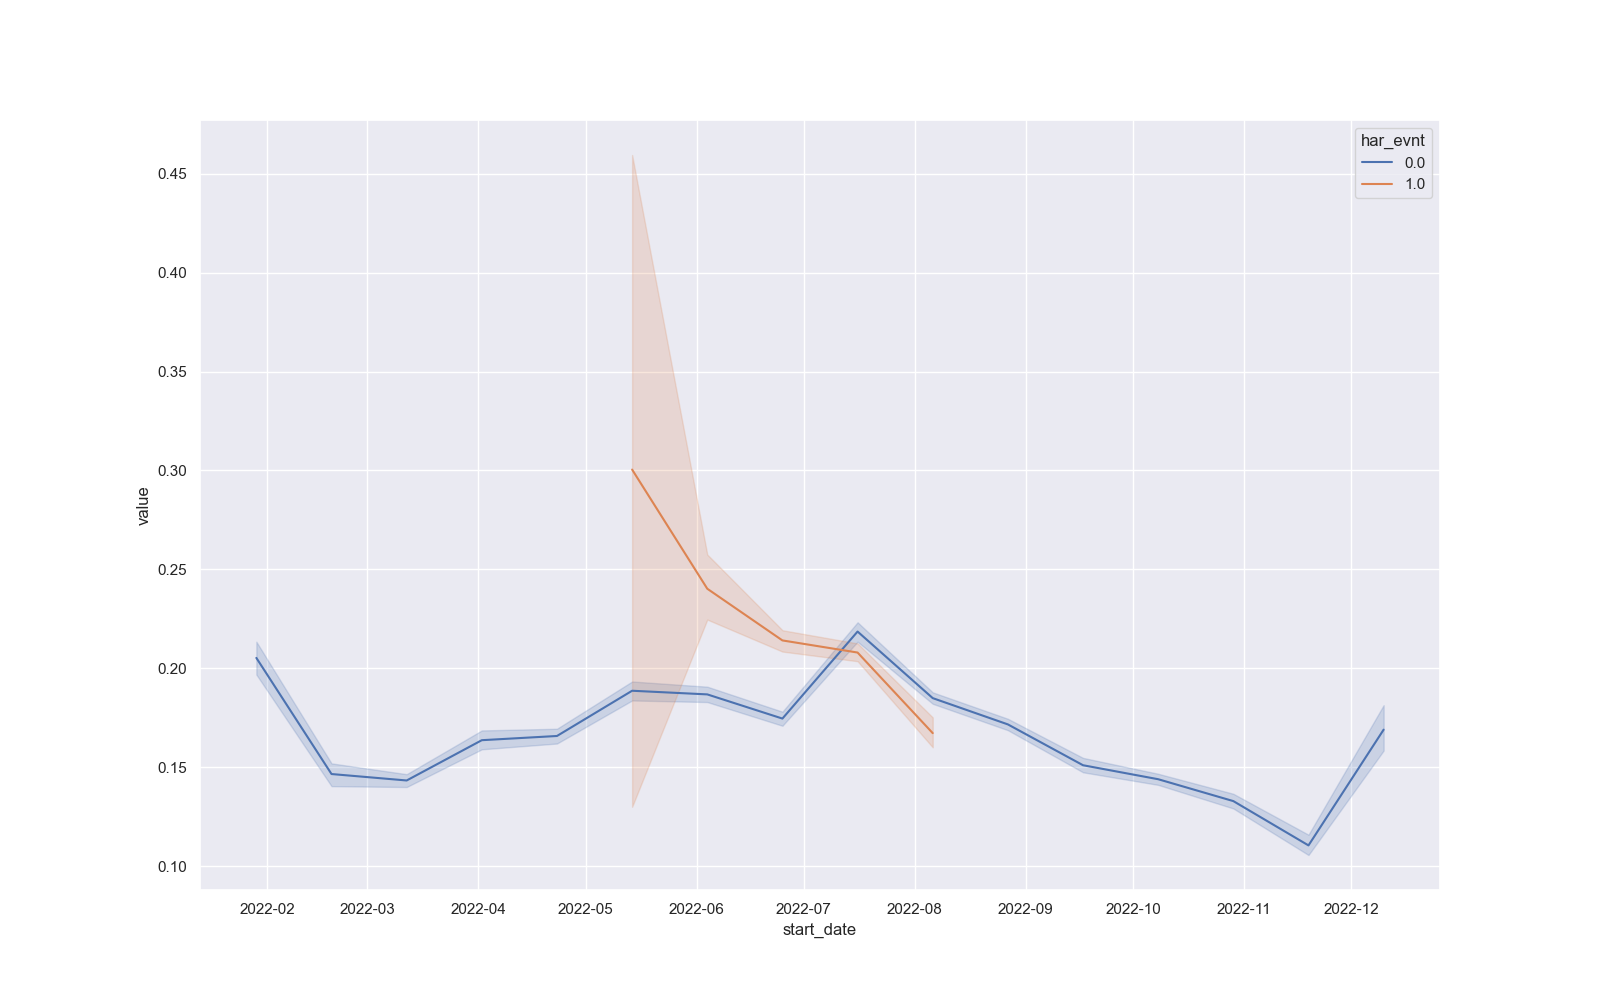

In [45]:

fig = plt.figure(figsize=(16,len(BANDS)))
sns.lineplot(x="start_date", y="value",
         hue="har_evnt", style="class",
         data=stretch_numeric_df)


fig = plt.figure(figsize=(16,len(BANDS)))
sns.lineplot(x="start_date", y="value",
         hue="har_evnt",
         data=stretch_numeric_df)


In [46]:
plt.ioff()

sns.set(rc={'figure.figsize':(len(BANDS) * 8, len(BANDS) * 5)})

fig, axes = plt.subplots(len(BANDS), 1)
fig.suptitle('Mean and 95% CI by Band')
fig.subplots_adjust(hspace=0.5, wspace=0.5)


for i in range(len(BANDS)):
    band_name = BANDS[i]
    sns.lineplot(ax=axes[i], x="finHarvDat", y=band_name,
        hue="har_evnt",
        data=df)
    sns.scatterplot(ax=axes[i], data=df, x="finHarvDat", y=band_name, hue="har_evnt", style="har_evnt", alpha=0.5)

    ax2 = axes[i].twinx()
    sns.histplot(ax=ax2, data=df, x="finHarvDat", bins=40, element="step", fill=False, color='green')
    if(i % 2 == 0):
        #axes[i].tick_params(bottom=False)
        #axes[i].legend_.remove()
        pass
    title = (BANDS_DICT[band_name] + f' ({band_name})')
    axes[i].set_title(title)


utilities.saveFigsAsPDF([fig], "../plots/line_plots/mean&CIByBand.pdf")
plt.ion()

../plots/line_plots/mean&CIByBand.pdf   saved!


In [45]:
plt.ioff()
sns.set(rc={'figure.figsize':(len(BANDS) * 8, len(BANDS) * 5)})
fig, axes = plt.subplots(len(BANDS), 1)
fig.suptitle('Median and IQR by Band')
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# https://stackoverflow.com/questions/52525476/seaborn-lineplot-using-median-instead-of-mean
for i in range(len(BANDS)):
    band_name = BANDS[i]
    sns.lineplot(ax=axes[i], x="finHarvDat", y=band_name,
        hue="har_evnt", estimator="median",errorbar=("pi", 50),# show inner quartile range #https://seaborn.pydata.org/tutorial/error_bars.html
        data=df)
    
    sns.scatterplot(ax=axes[i], data=df, x="finHarvDat", y=band_name, hue="har_evnt", style="har_evnt", alpha=0.5)

    ax2 = axes[i].twinx()
    sns.histplot(ax=ax2, data=df, x="finHarvDat", bins=40, element="step", fill=False, color='green')

    if(i % 2 == 0):
        #axes[i].tick_params(bottom=False)
        #axes[i].legend_.remove()
        pass

    title = (BANDS_DICT[band_name] + f' ({band_name})')
    axes[i].set_title(title)
utilities.saveFigsAsPDF([fig], "../plots/line_plots/median&IQRByBand.pdf")
plt.ion()

../plots/line_plots/median&IQRByBand.pdf   saved!


In [94]:
df1 = df[df.har_evnt]
df2 = df[df.har_evnt == False]
for col_name in NUMERIC_COLS:
    df1[col_name] = utilities.rmved_outliers_iqr(df1[col_name])
for col_name in NUMERIC_COLS:
    df2[col_name] = utilities.rmved_outliers_iqr(df2[col_name])

df_trimmed = pd.concat([df1, df2])

/Users/tahaalnufaili/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-Fyp2lGEN-py3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tahaalnufaili/Library/Caches/pypoetry/virtualenvs/harvest-event-detec-Fyp2lGEN-py3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/tahaalnufaili/Library/Caches/pypoetry/virtual

In [95]:
har = (df[df.har_evnt][['NDVI']])

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,...,RVI,ARVI,NDI45,GNDVI,MCARI,IRECI,CIr,NDVIre,NIRv,EVI
4,0.16620,0.13040,0.03920,0.05140,0.0719,0.07380,0.08200,0.08860,0.10920,0.09940,...,0.658425,1.854902,0.013040,0.359900,-0.000005,0.018556,0.200542,0.193443,0.014809,0.074803
10,0.18645,0.11870,0.03375,0.05155,0.0515,0.10150,0.19885,0.22375,0.24530,0.23850,...,0.209947,1.156010,0.326797,0.652687,0.002001,0.337457,1.204433,0.414648,0.033628,0.372356
12,0.15740,0.10770,0.03780,0.05100,0.0508,0.12060,0.16800,0.17880,0.17800,0.19260,...,0.285393,1.157576,0.407235,0.554585,0.003900,0.178308,0.482587,0.192230,0.028242,0.265155
14,0.15355,0.13335,0.02390,0.02820,0.0401,0.04600,0.05485,0.06245,0.07085,0.07545,...,0.565984,1.592864,0.068525,0.430591,0.000014,0.026650,0.357609,0.212666,0.011114,0.067899
15,0.21385,0.15000,0.05220,0.08115,0.0941,0.13110,0.18360,0.19200,0.21910,0.21475,...,0.429484,1.472912,0.164298,0.459450,0.000999,0.137105,0.464531,0.251285,0.037556,0.224465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,0.16560,0.12870,0.02840,0.04430,0.0583,0.07240,0.08450,0.09450,0.10320,0.11110,...,0.564922,1.815825,0.107881,0.399322,0.000120,0.042250,0.305249,0.175399,0.016208,0.090524
8905,0.23220,0.18640,0.05320,0.06880,0.0902,0.09580,0.10330,0.10710,0.12640,0.12540,...,0.713608,1.827740,0.030108,0.295082,0.000001,0.018223,0.117954,0.137714,0.015075,0.071338
8910,0.16480,0.11750,0.06640,0.05670,0.0668,0.07670,0.08850,0.09330,0.11880,0.10590,...,0.562290,1.006757,0.068990,0.353846,0.000058,0.030577,0.216428,0.215345,0.018716,0.127251
8917,0.33080,0.22820,0.14280,0.16420,0.1500,0.23870,0.50140,0.55840,0.60760,0.58570,...,0.246873,1.023984,0.228197,0.574501,0.006546,0.857862,1.339338,0.435897,0.090602,0.796325


<Axes: xlabel='NDVI', ylabel='Count'>

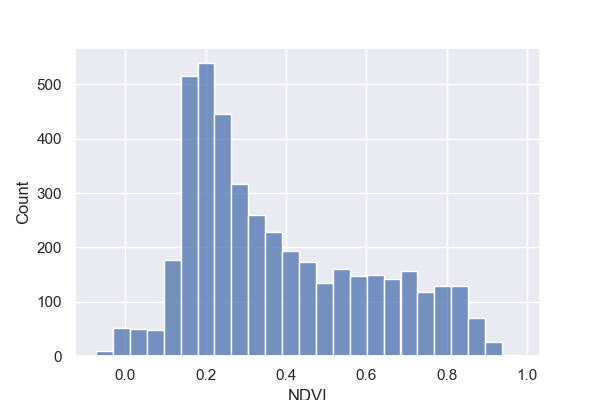

In [120]:
arr, bools = utilities.rmved_outliers_iqr(df['NDVI'], True)
fig = plt.figure(figsize=(6,4))
sns.histplot(df[bools == False], x='NDVI')

<Axes: xlabel='NDVI', ylabel='Count'>

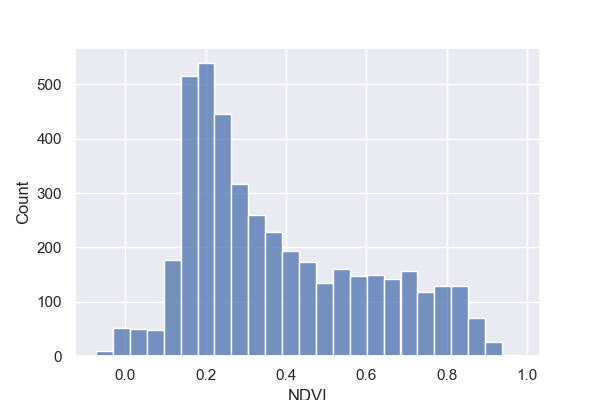

In [121]:
arr, bools = utilities.rmved_outliers_iqr(df['NDVI'], True)
fig = plt.figure(figsize=(6,4))
sns.histplot(df, x='NDVI')

<Axes: xlabel='NDVI', ylabel='Count'>

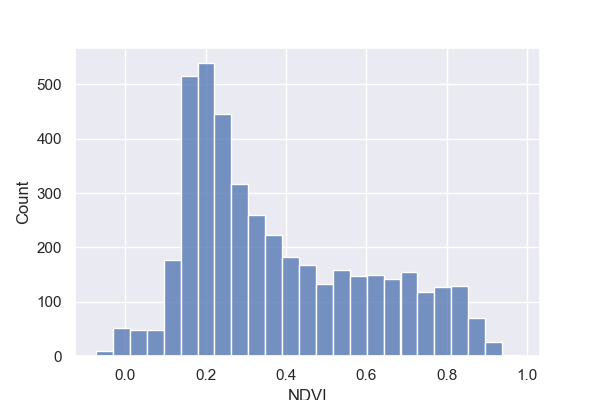

In [71]:
fig = plt.figure(figsize=(6,4))
sns.histplot(df_trimmed[['NDVI']].dropna(), x='NDVI')

<Axes: xlabel='NDVI', ylabel='Count'>

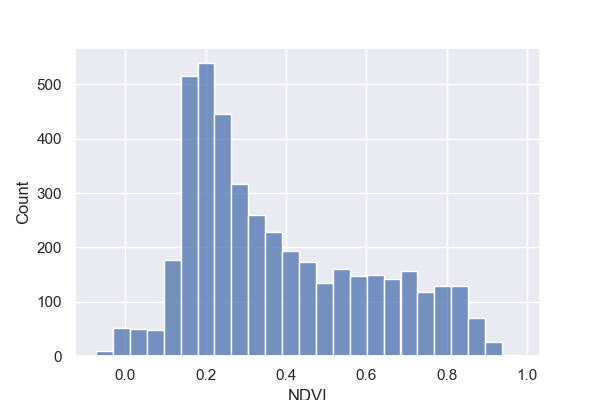

In [72]:
fig = plt.figure(figsize=(6,4))
sns.histplot(df, x='NDVI')

# PCA

In [ ]:
pca = PCA(n_components=3)
numeric_col_values = (df.loc[:, NUMERIC_COLS]).copy().values
pca_result = pca.fit_transform(numeric_col_values)

df['pca_one'] = pca_result[:,0]
df['pca_two'] = pca_result[:,1] 
df['pca_three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

In [ ]:
fig = plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca_one", y="pca_two",
    hue= 'sample_idx',
    palette=sns.color_palette("brg", NUM_SAMPLES),
    data=df,
    alpha=0.4,
    legend="full"
)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

p = ax.scatter(
    xs=df["pca_one"], 
    ys=df["pca_two"], 
    zs=df["pca_three"], 
    color= df['har_evnt'].apply(lambda x: "red" if(x) else "blue"),
    alpha=0.5
    )

ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
colors = distinctipy.get_colors(NUM_SAMPLES)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

p = ax.scatter(
    xs=df["pca_one"], 
    ys=df["pca_two"], 
    zs=df["pca_three"], 
    color= df['sample_idx'].apply(lambda x: colors[int(x[1:])]),
    alpha=0.5,
    )

ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

plt.show()

In [ ]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

p = ax.scatter(
    xs=df["pca_one"], 
    ys=df["pca_two"], 
    zs=df["pca_three"], 
    c=df["NDVI"], 
    cmap='brg'
    )

ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')

fig.colorbar(p, ax=ax)
plt.show()

# T-NSE

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(numeric_col_values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df['tsne_2d_one'] = tsne_results[:,0]
df['tsne_2d_two'] = tsne_results[:,1]

In [ ]:
fig = plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="sample_idx",
    palette=sns.color_palette("hls", NUM_SAMPLES),
    data=df,
    legend="full",
    alpha=0.5
)

fig = plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_2d_one", y="tsne_2d_two",
    hue="har_evnt",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.5
)

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(numeric_col_values.copy())

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df['tsne_3d_one'] = tsne_results[:,0]
df['tsne_3d_two'] = tsne_results[:,1]
df['tsne_3d_three'] = tsne_results[:,2]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

p = ax.scatter(
    xs=df["tsne_3d_one"], 
    ys=df["tsne_3d_two"], 
    zs=df["tsne_3d_three"], 
    c=df["NDVI"], 
    cmap='brg'
    )

ax.set_xlabel('tsne_3d_one')
ax.set_ylabel('tsne_3d_two')
ax.set_zlabel('tsne_3d_three')

fig.colorbar(p, ax=ax)
plt.show()



fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

p = ax.scatter(
    xs=df["tsne_3d_one"], 
    ys=df["tsne_3d_two"], 
    zs=df["tsne_3d_three"], 
    c=df["har_evnt"],
    cmap='Paired'
    )

ax.set_xlabel('tsne_3d_one')
ax.set_ylabel('tsne_3d_two')
ax.set_zlabel('tsne_3d_three')

fig.colorbar(p, ax=ax)
plt.show()

In [ ]:
x = np.empty(NUM_SAMPLES)
y = np.zeros(NUM_SAMPLES)

for sample_idx in range(NUM_SAMPLES):
    curr_df = df.loc[df['sample_idx'] == 's'+str(sample_idx)]
    x = curr_df['']

In [ ]:

title = "finHarvDat By Sample's Date Range"
my_bins = pd.date_range(start=min(df.start_date), end=max(df.end_date),freq='3W')
sns.displot(data=curr_df,x="finHarvDat", bins=matplotlib.dates.date2num(my_bins)).set(title=title)


In [ ]:
sns.displot(data=curr_df,x="finHarvDat", bins=40)

In [ ]:
366 plots for harvest 
366 for non harvest




In [ ]:
experiment with vegetation measurments other than ndvi

In [37]:
plt.ioff()

sns.set(rc={'figure.figsize':(len(BANDS) * 8, len(BANDS) * 5)})

fig, axes = plt.subplots(len(BANDS), 1)
fig.suptitle('mean&CIByBand & frequencies by Band')
fig.subplots_adjust(hspace=0.5, wspace=0.5)


for i in range(len(BANDS)):
    band_name = BANDS[i]
    sns.lineplot(ax=axes[i], x="finHarvDat", y=band_name,
        hue="har_evnt",
        data=df)
    ax2 = axes[i].twinx()
    sns.histplot(ax=ax2, data=df, x="finHarvDat", bins=40, element="step", fill=False)
    if(i % 2 == 0):
        #axes[i].tick_params(bottom=False)
        #axes[i].legend_.remove()
        pass
    title = (BANDS_DICT[band_name] + f' ({band_name})')
    axes[i].set_title(title)


utilities.saveFigsAsPDF([fig], "../plots/line_plots/mean&CIByBand_freqs.pdf")
plt.ion()

../plots/line_plots/mean&CIByBand_freqs.pdf   saved!
